In [2]:
import pandas as pd
import json
import re
import numpy as np
import os


Prior to parsing, spurious responses were purged on the basis of:

All extreme values
Inappropriate comments
Non-target user profile

## Data parsing

In [40]:
# Loading Data
RESULTS_FILEPATH = "data/20210715082420_results.json"
figure_save_dir = os.path.splitext(RESULTS_FILEPATH)[0]

ids_to_exclude = [
    "1624013360083", #inappropriate comment, extreme values
    "1623688924533", #test input
    ]

with open(RESULTS_FILEPATH) as f:
    # remove image0/image1 vars since it prevents proper df merging
    text = f.read()
    text = re.sub(r"_image[0-3]", "", text)
    text = re.sub(r"user_profiling_", "user_", text)
    text = re.sub(r"user_", "userProfiling_", text)
    lines = text.splitlines()
    data = []
    for line in lines[1:-1]:
        entry = json.loads(line)
        entry["id"] = str(round(entry["id"]))
        data.append(entry)
    df = pd.json_normalize(data)
    df.drop(labels=["__v", "_id.$oid"], axis=1, inplace=True)

# hacky solution to remove the panda-appended user_. entry
renamed = [name.split("_.")[-1] for name in df.columns]
col_rename = {i: j for i, j in zip(df.columns, renamed)}
df = df.rename(columns=col_rename)
df.drop_duplicates(subset=['id'], inplace=True)

df = df[~df.id.isin(ids_to_exclude)]
df = df[df.userProfiling_position != "other"]
df.set_index("id", inplace=True)
df

,userProfiling_age,userProfiling_position,userProfiling_useOfAI,userProfiling_useOfDP,userProfiling_mlFamiliarity,saliencyMaps_globalSaliency_understandability,saliencyMaps_globalSaliency_usability,saliencyMaps_globalSaliency_informativeness,saliencyMaps_globalSaliency_value,saliencyMaps_localSaliency_understandability,...,userProfiling_useOfAI_details,saliencyMaps_globalSaliency_comments,saliencyMaps_localSaliency_comments,conceptAttribution_textAttributes_comments,trustScores_borderlineCases_comments,userProfiling_aiFamiliarity,userProfiling_comments,counterfactuals_twoAxisCounterfactuals_comments,counterfactuals_prototypeInterpolation_comments,userProfiling_position-Comment
id,,,,,,,,,,,,,,,,,,,,,
1623319499818,30-40,Assisting physician (Assistenzarzt) for pathol...,in routine diagnostics,in routine diagnostics,1,5,5,6,6,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623330321488,41-50,Researcher in pathology/neuropathology,in research,in research,3,7,7,7,7,6,...,"from MindPeak (BreastIHC), from VMscope (Cogni...",There is one cell slightly to the right of the...,Per-cell saliency is probably too much detail.,This is excellent but I think there could be q...,High confidence should provide examples of bot...,NaN,NaN,NaN,NaN,NaN
1623391402856,30-40,Researcher in pathology/neuropathology,[in research],[in research],7,6,3,4,5,3,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
1623391916479,41-50,Technician (MTA) for pathology/neuropathology,[in routine diagnostics],[in research],7,5,7,3,6,5,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
1623439901422,30-40,Trainee (Assistenzarzt) in pathology/neuropath...,[in research],[in research],2,4,5,6,4,5,...,QuPath immunohistochemistry positive cell dete...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
1623441394465,30-40,Consultant (Facharzt) for pathology/neuropatho...,[in research],[in research],7,6,5,5,6,5,...,Aiforia,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
1623655000204,51-60,Researcher in pathology/neuropathology,[none],[none],2,5,5,5,5,6,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
1623674498302,41-50,Consultant (Facharzt) for pathology/neuropatho...,[none],[in routine diagnostics],4,1,1,1,1,1,...,NaN,NaN,NaN,NaN,Confidence for what? positive or negative or b...,5.0,NaN,NaN,NaN,NaN
1623676868025,41-50,Consultant (Facharzt) for pathology/neuropatho...,[none],[none],5,3,3,2,2,4,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN


In [41]:
user_df = df[
    [
        "userProfiling_age",
        "userProfiling_position",
        "userProfiling_useOfDP",
        "userProfiling_useOfAI",
        "userProfiling_useOfAI_details",
        "userProfiling_mlFamiliarity",
    ]
]

fields = ["Understandability", "Usability", "Informativeness", "Value"]

instance_identifiers = {
    "Counterfactuals: Single axis": "counterfactuals_prototypeInterpolation",
    "Counterfactuals: Two axes": "counterfactuals_twoAxisCounterfactuals",
    "Saliency Maps: Local": "saliencyMaps_localSaliency",
    "Saliency Maps: Global": "saliencyMaps_globalSaliency",
    "Concept Attribution: Text": "conceptAttribution_textAttributes",
    "Prototypes: Highest confidence": "prototypes_prototypes",
    "Trust Scores: Borderline Cases": "trustScores_borderlineCases",
}

result_dataframes = dict()
comments = dict()
for name, id_ in instance_identifiers.items():
    result_dataframes[name] = df[[f"{id_}_{field.lower()}" for field in fields]]
    result_dataframes[name].columns = fields

    comments_column = f"{id_}_comments"
    if comments_column in df.columns:
        comments[name] = df[[comments_column]].dropna().values.squeeze(axis=1).tolist()
    else:
        comments[name] = []

result_dataframes["Counterfactuals: Single axis"]


,Understandability,Usability,Informativeness,Value
id,,,,
1623319499818,6,6,7,6
1623330321488,7,7,7,7
1623391402856,4,6,4,5
1623391916479,6,4,5,5
1623439901422,3,2,2,1
1623441394465,7,7,7,7
1623655000204,2,2,2,2
1623674498302,7,4,6,5
1623676868025,5,6,5,5


In [42]:
comments


{'Counterfactuals: Single axis': ["Like previous, initial reaction is that interpolation is useful but doesn't give the full picture of possible negatives. Perhaps clicking around each cell and seeing the interpolation for each would feel more useful",
  'What is a counterfactual? '],
 'Counterfactuals: Two axes': ['It seems there may be many counterfactual examples that are more closely related to the positive example which could be useful for understanding the nuances and building trust',
  'Do not understand this question'],
 'Saliency Maps: Local': ['Per-cell saliency is probably too much detail. '],
 'Saliency Maps: Global': ['There is one cell slightly to the right of the center that is labeled as positive and is quite darkly stained by IHC, but does not show up on the saliency map, which is a bit surprising. It looks like an endothelial cell. '],
 'Concept Attribution: Text': ['This is excellent but I think there could be quite a lot of additional factors, so this would need som

In [43]:
user_df


,userProfiling_age,userProfiling_position,userProfiling_useOfDP,userProfiling_useOfAI,userProfiling_useOfAI_details,userProfiling_mlFamiliarity
id,,,,,,
1623319499818,30-40,Assisting physician (Assistenzarzt) for pathol...,in routine diagnostics,in routine diagnostics,NaN,1
1623330321488,41-50,Researcher in pathology/neuropathology,in research,in research,"from MindPeak (BreastIHC), from VMscope (Cogni...",3
1623391402856,30-40,Researcher in pathology/neuropathology,[in research],[in research],NaN,7
1623391916479,41-50,Technician (MTA) for pathology/neuropathology,[in research],[in routine diagnostics],NaN,7
1623439901422,30-40,Trainee (Assistenzarzt) in pathology/neuropath...,[in research],[in research],QuPath immunohistochemistry positive cell dete...,2
1623441394465,30-40,Consultant (Facharzt) for pathology/neuropatho...,[in research],[in research],Aiforia,7
1623655000204,51-60,Researcher in pathology/neuropathology,[none],[none],NaN,2
1623674498302,41-50,Consultant (Facharzt) for pathology/neuropatho...,[in routine diagnostics],[none],NaN,4
1623676868025,41-50,Consultant (Facharzt) for pathology/neuropatho...,[none],[none],NaN,5


## Overall comparison

## Stacked diverging bar charts

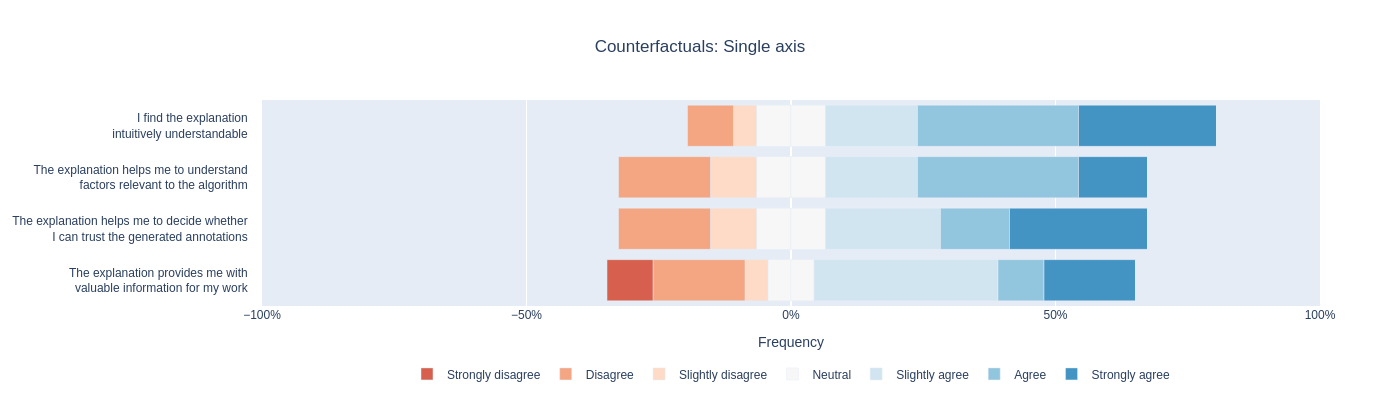

Like previous, initial reaction is that interpolation is useful but doesn't give the full picture of possible negatives. Perhaps clicking around each cell and seeing the interpolation for each would feel more useful
What is a counterfactual? 


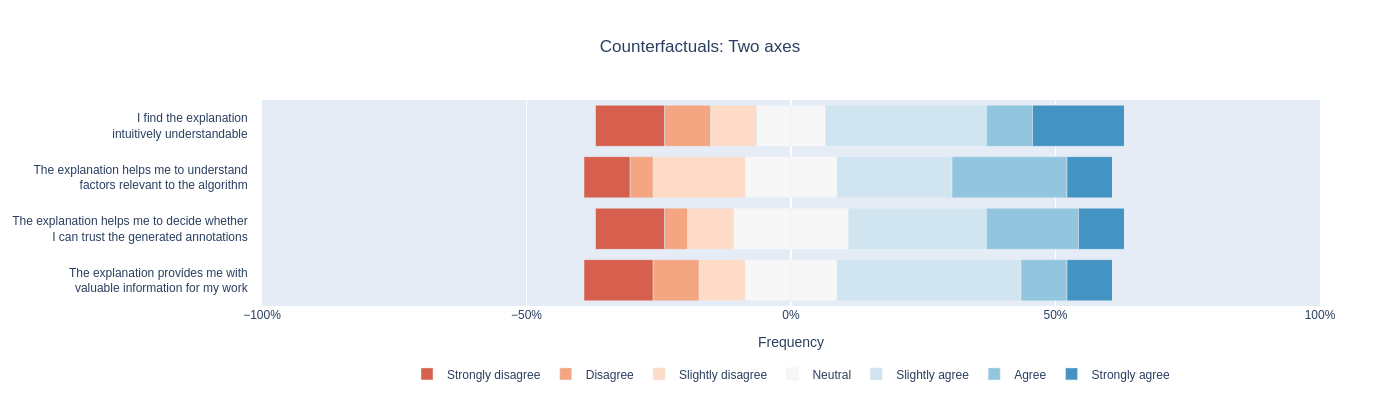

It seems there may be many counterfactual examples that are more closely related to the positive example which could be useful for understanding the nuances and building trust
Do not understand this question


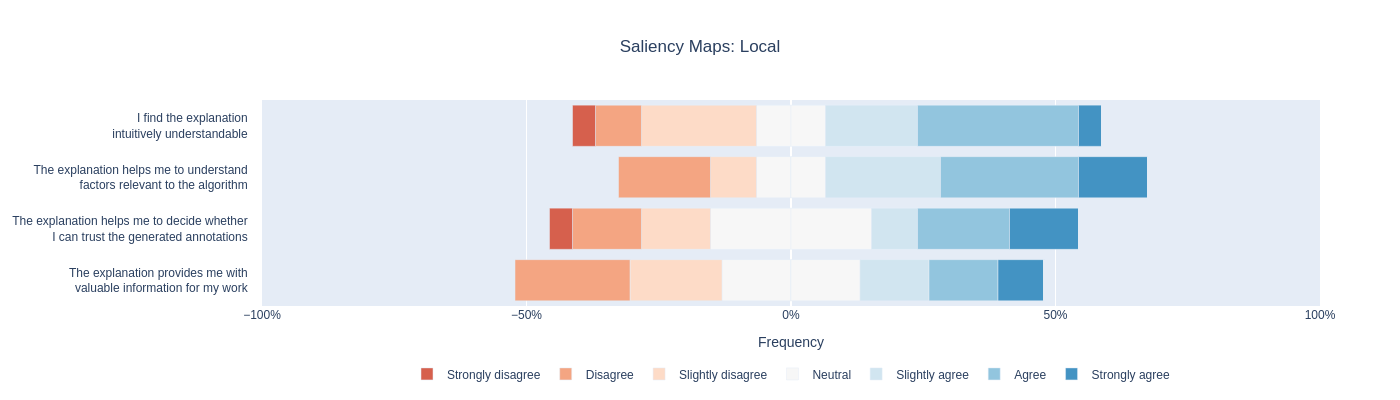

Per-cell saliency is probably too much detail. 


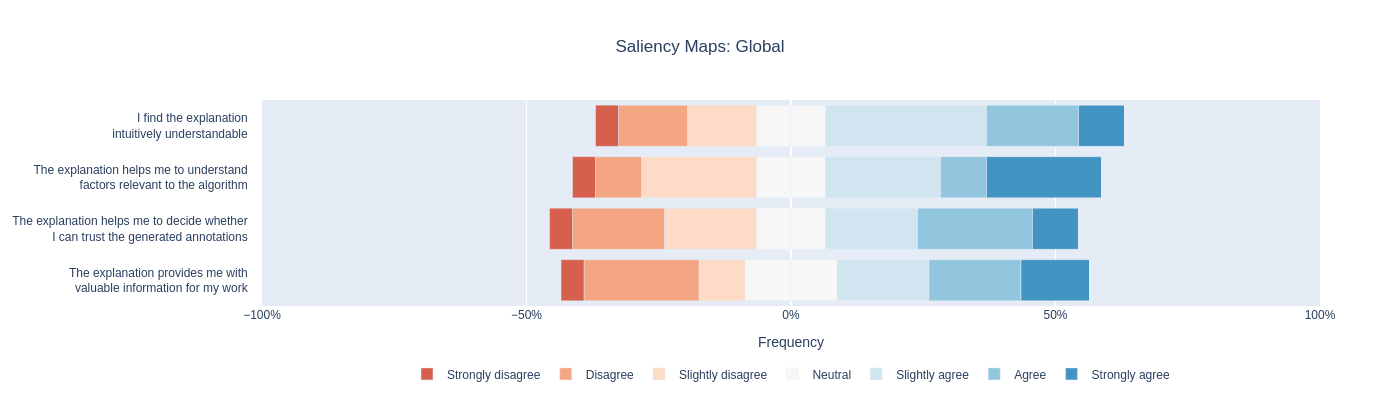

There is one cell slightly to the right of the center that is labeled as positive and is quite darkly stained by IHC, but does not show up on the saliency map, which is a bit surprising. It looks like an endothelial cell. 


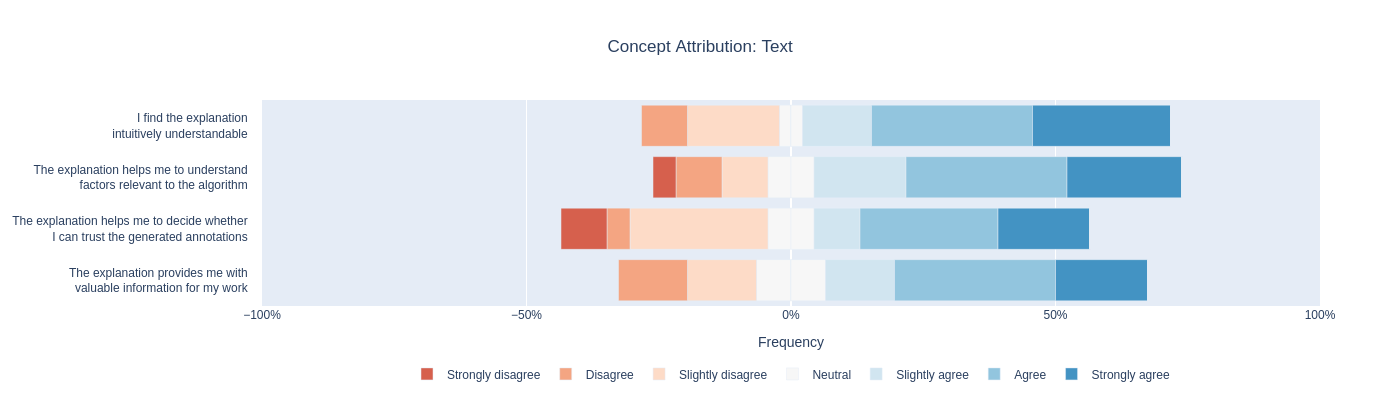

This is excellent but I think there could be quite a lot of additional factors, so this would need some supervision. 


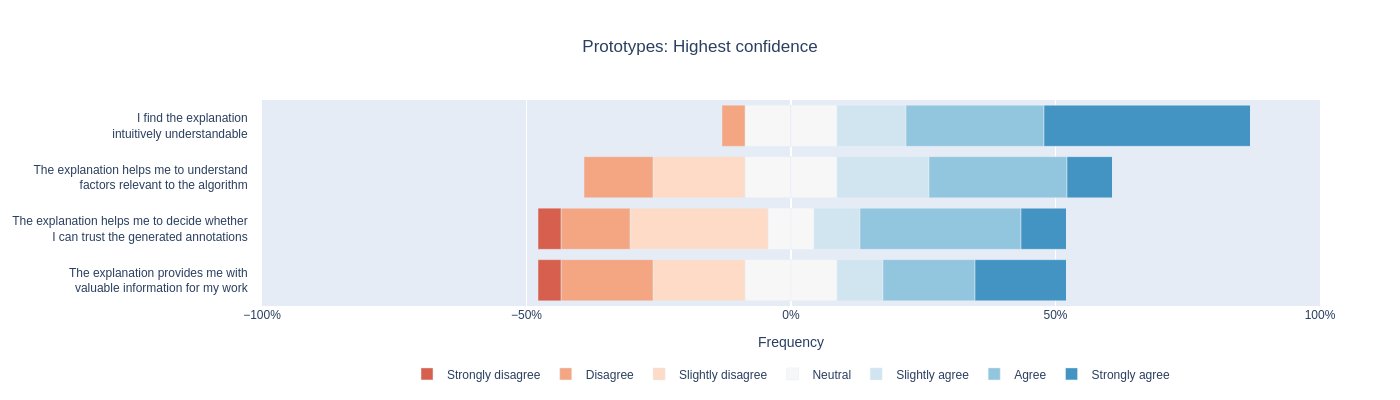

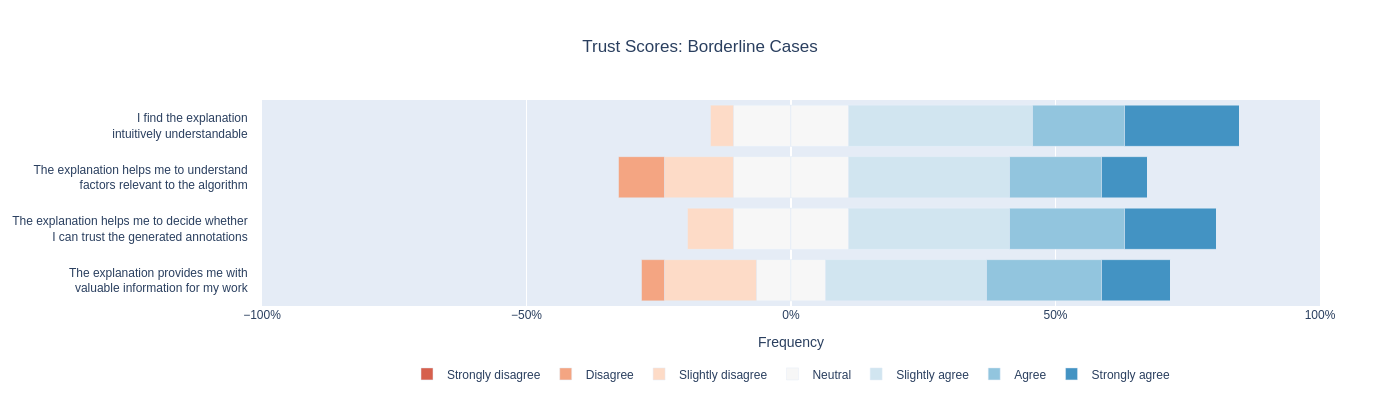

High confidence should provide examples of both classes (pos. and neg.), no? 
Confidence for what? positive or negative or both?
I felt I needed the pos or neg labels in addition to the confidence


In [44]:
from typing import Optional
from collections import Counter

import plotly
import plotly.graph_objects as go

from PIL import Image
import io
from IPython.display import display

def plotly_figure_to_image(fig, extension: str = 'png', **kwargs):
    img_bytes = fig.to_image(format=extension, **kwargs)
    return Image.open(io.BytesIO(img_bytes))

def save_image(image, name: str, save_dir: str = "images", extension: str="png"):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    filename = "".join(i for i in name if i not in "\\/:*?<>| ")
    filepath = f"{save_dir}/{filename}.{extension}"
    image.save(filepath)

def stackedBarChartDF(
    df: pd.DataFrame,
    title: str,
    palette: list,
    attributes: list = ["Understandability", "Usability", "Informativeness", "Value"],
    labels: Optional[list] = None,
    save_fig: bool = False,
    save_dir: str = "images",
    web_display: bool = False
):
    counters = [Counter(df[attribute]) for attribute in attributes]

    fig = go.Figure()  # type: ignore

    category_order = [
        "Strongly disagree",
        "Disagree",
        "Slightly disagree",
        "Neutral",
        "Slightly agree",
        "Agree",
        "Strongly agree",
    ]

    number_order = [1, 2, 3, 4, 5, 6, 7]

    labels = labels if labels else attributes

    def add_bar_trace(num, transform, showlegend: bool = True):
        rating = number_order[num]
        counts = [counter[rating] for counter in counters]
        total_count = sum(counters[0].values())

        xvals = [transform(count) / total_count for count in counts]

        fig.add_trace(
            go.Bar(
                x=xvals,
                y=labels,
                orientation="h",
                name=category_order[num],
                width=0.8,
                marker_color=palette[num],
                showlegend=False,
            )  # type: ignore
        )

    # negative side
    add_bar_trace(3, lambda x: x * -0.5)
    for num in reversed(range(0, 3)):
        add_bar_trace(num, lambda x: x * -1)

    # positive side
    add_bar_trace(3, lambda x: x * 0.5, showlegend=False)
    for num in range(4, 7):
        add_bar_trace(num, lambda x: x)

    for num in range(0, 7):
        fig.add_trace(
            go.Bar(
                x=[0] * 7,
                y=labels,
                orientation="h",
                name=category_order[num],
                marker_color=palette[num],
            )  # type: ignore
        )
    fig.update_layout(
        barmode="relative",
        yaxis_autorange="reversed",
        title=dict(
            text=title,
            x=0.5,
            y=0.9
            ),
        xaxis={"tick0": 0, "title": "Frequency", "tickformat": "%", "range": [-1, 1]},
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.4,
            xanchor="center",
            x=0.5,
        ),
    )
    im = plotly_figure_to_image(fig, width=1400, height=400, validate=True)
    
    if web_display: 
        fig.show()
    else:  
        display(im)

    if save_fig:
        save_image(im, name, save_dir)


palette = [plotly.colors.diverging.RdBu[n] for n in [2, 3, 4, 5, 6, 7, 8]]  # type: ignore
space = " " * 4
labels = [
    f"I find the explanation{space}<br>intuitively understandable{space}",
    f"The explanation helps me to understand{space}<br>factors relevant to the algorithm{space}",
    f"The explanation helps me to decide whether{space}<br> I can trust the generated annotations{space}",
    f"The explanation provides me with{space}<br>valuable information for my work{space}",
]

for name, df in result_dataframes.items():
    stackedBarChartDF(
        df,
        name,
        palette,
        labels=labels,
        save_fig=True,
        save_dir=figure_save_dir,
    )
    for comment in comments[name]:
        print(comment)


In [45]:
import plotly.express as px

for name, result in result_dataframes.items():
    print('\n'+name)
    px.imshow(result.corr(method='spearman'), zmin=0, width = 500, height=300).show()


Counterfactuals: Single axis



Counterfactuals: Two axes



Saliency Maps: Local



Saliency Maps: Global



Concept Attribution: Text



Prototypes: Highest confidence



Trust Scores: Borderline Cases


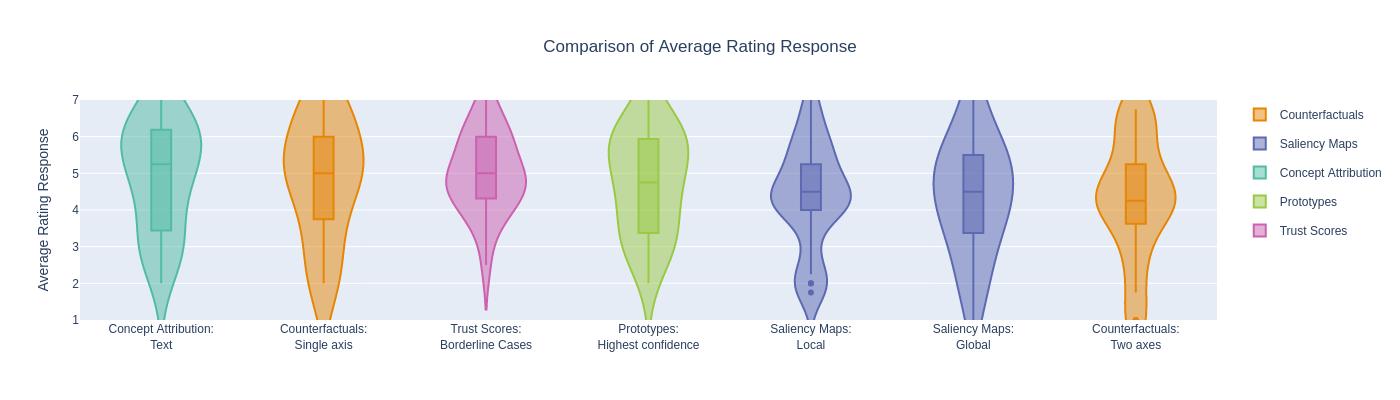

In [55]:
import plotly.express as px

from typing import Callable, Optional

dfFilter = Optional[Callable[[pd.DataFrame], pd.DataFrame]]

def boxPlotDF(
    df: pd.DataFrame,
    title: str,
    palette: list,
    filter_neg: dfFilter = None,
    filter_pos: dfFilter = None,
    save_fig: bool = False,
    save_dir: str = "images",
    web_display: bool = False,
    **kwargs
):
    explanation_classes = [
        "Counterfactuals",
        "Saliency Maps",
        "Concept Attribution",
        "Prototypes",
        "Trust Scores",
    ]

    color_dict = {
        explanation_class: palette[idx]
        for idx, explanation_class in enumerate(explanation_classes)
    }

    columns = (column for column in df if column in instance_identifiers)

    results_only_df = df[[column for column in columns]]
    sorted_index = results_only_df.median().sort_values(ascending=False).index
    results_only_df = df[sorted_index]

    fig = go.Figure()  # type: ignore
    for column in results_only_df:
        split_column = column.split(": ")
        explanation_class = split_column[0]
        column_name = f"{explanation_class}:<br>{split_column[1]}"
        fig.add_trace(
            go.Violin(
                y=df[column][filter_neg(df)] if filter_neg else df[column],
                name=column_name,
                box_visible=True,
                marker_color=color_dict[explanation_class],
                legendgroup=explanation_class,
                showlegend=False,
                side="negative" if filter_pos else "both",
            )  # type: ignore
        )
        if filter_pos:
            fig.add_trace(
            go.Violin(
                y=df[column][filter_pos(df)],
                name=column_name,
                box_visible=True,
                marker_color=color_dict[explanation_class],
                legendgroup=explanation_class,
                showlegend=False,
                side="positive",
            )  # type: ignore
        )

    if kwargs:
        fig.update_traces(**kwargs)

    # Legend
    for explanation_class in explanation_classes:
        fig.add_trace(
            go.Violin(
                y=[None],
                name=explanation_class,
                marker_color=color_dict[explanation_class],
                legendgroup=explanation_class,
                showlegend=True,
            )  # type: ignore
        )

    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            y=0.9),
        yaxis=dict(dtick=1),
        yaxis_range=[1, 7],
        yaxis_title="Average Rating Response",
        showlegend=True,
    )

    im = plotly_figure_to_image(fig, width=1400, height=400)
    
    if web_display: 
        fig.show()
    else:  
        display(im)

    if save_fig:
        save_image(im, title, save_dir)


aggregated_df = pd.DataFrame()
for name, df in result_dataframes.items():
    aggregated_df[name] = df.mean(axis=1)

full_df = user_df.join(aggregated_df)

boxPlotDF(
    full_df, "Comparison of Average Rating Response", 
    plotly.colors.qualitative.Vivid, # type: ignore
    save_fig=True, 
    save_dir=figure_save_dir,
    scalemode='count'
    )  

aggregated_df = pd.DataFrame()
for name, df in result_dataframes.items():
    aggregated_df[name] = df['Value']

full_df = user_df.join(aggregated_df)

boxPlotDF(
    full_df, "Comparison of responses to value question", 
    plotly.colors.qualitative.Vivid, # type: ignore
    web_display=True
    )  

In [56]:
filter_1 = lambda df: df.userProfiling_position.str.startswith("Consultant")
filter_2 = lambda df: ~df.userProfiling_position.str.startswith("Consultant")

boxPlotDF(
    full_df, "Comparison of Average Rating Response", 
    plotly.colors.qualitative.Vivid, # type: ignore
    filter_neg=filter_1,
    filter_pos=filter_2,
    web_display=True,
    )  


## User profiling

In [54]:
full_df

,userProfiling_age,userProfiling_position,userProfiling_useOfDP,userProfiling_useOfAI,userProfiling_useOfAI_details,userProfiling_mlFamiliarity,Counterfactuals: Single axis,Counterfactuals: Two axes,Saliency Maps: Local,Saliency Maps: Global,Concept Attribution: Text,Prototypes: Highest confidence,Trust Scores: Borderline Cases
id,,,,,,,,,,,,,
1623319499818,30-40,Assisting physician (Assistenzarzt) for pathol...,in routine diagnostics,in routine diagnostics,NaN,1,6,5,5,6,6,6,6
1623330321488,41-50,Researcher in pathology/neuropathology,in research,in research,"from MindPeak (BreastIHC), from VMscope (Cogni...",3,7,6,4,7,7,7,3
1623391402856,30-40,Researcher in pathology/neuropathology,[in research],[in research],NaN,7,5,5,4,5,6,7,6
1623391916479,41-50,Technician (MTA) for pathology/neuropathology,[in research],[in routine diagnostics],NaN,7,5,7,6,6,7,7,6
1623439901422,30-40,Trainee (Assistenzarzt) in pathology/neuropath...,[in research],[in research],QuPath immunohistochemistry positive cell dete...,2,1,2,3,4,2,2,5
1623441394465,30-40,Consultant (Facharzt) for pathology/neuropatho...,[in research],[in research],Aiforia,7,7,6,5,6,4,7,5
1623655000204,51-60,Researcher in pathology/neuropathology,[none],[none],NaN,2,2,1,6,5,4,4,5
1623674498302,41-50,Consultant (Facharzt) for pathology/neuropatho...,[in routine diagnostics],[none],NaN,4,5,4,2,1,3,3,2
1623676868025,41-50,Consultant (Facharzt) for pathology/neuropatho...,[none],[none],NaN,5,5,4,4,2,3,5,6
